# Prétraitement des données clients e-commerce

Dans le cadre de cette mission, nous intervenons en tant que consultant pour Olist, une entreprise brésilienne spécialisée dans les solutions de vente sur les marketplaces en ligne.

L’objectif principal est de fournir une segmentation client exploitable aux équipes e-commerce d’Olist, afin de les aider à mieux cibler leurs campagnes de communication.

Pour cela, nous allons :

Analyser les données comportementales et personnelles des utilisateurs ;

Identifier des groupes de clients distincts selon des logiques de segmentation claires ;

Décrire chaque segment de manière actionnable et compréhensible pour les équipes marketing ;

Proposer un modèle de maintenance de la segmentation, fondé sur l’analyse de la stabilité des segments dans le temps.

Ce travail permettra aux équipes d’Olist de personnaliser leurs actions marketing avec plus de précision et d’agilité.

Ce notebook prépare les données clients pour la segmentation marketing. 

## Import des librairies

On importe les librairies nécessaires pour la manipulation, l'analyse et la visualisation des données.

In [1]:
# Librairies import
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Import des fonctions utilitaires
import sys
sys.path.append('../src')
from ecomuserseg.utils import haversine_distance, check_datasets_info, load_brazil_states_info
from ecomuserseg.data_processing import (merge_products_categories, merge_orders_items, 
                                        convert_datetime_columns, add_payment_info, add_review_info)
from ecomuserseg.feature_engineering import (calculate_delivery_delay, categorize_products,
                                           calculate_categories_per_customer, calculate_products_per_order,
                                           calculate_purchase_recency, aggregate_customer_data, impute_missing_values)
from ecomuserseg.mlflow_tracking import setup_mlflow_experiment, log_data_preprocessing

# Import des paramètres
sys.path.append('../settings')
from params import DATA_PARAMS, FEATURE_ENGINEERING_PARAMS, VISUALIZATION_PARAMS

# Configuration MLflow
experiment_id = setup_mlflow_experiment("ecomuserseg_preprocessing")
print(f"Expérience MLflow configurée: {experiment_id}")

MLflow tracking URI: file:///Users/mac/Desktop/DIC3/MLOps/MLOps_project/ecomuserseg/mlruns
Nouvelle expérience créée: ecomuserseg_preprocessing (ID: 178081276325678275)
Expérience MLflow configurée: 178081276325678275


## Chargement des jeux de données

On charge tous les fichiers CSV nécessaires à l'analyse (clients, commandes, produits, paiements, avis, géolocalisation, etc.).

In [2]:
# Chargement des datasets avec paramètres centralisés
root_path = DATA_PARAMS["ROOT_PATH"]
data_files = DATA_PARAMS["DATA_FILES"]

customers = pd.read_csv(root_path + data_files["customers"])
orders = pd.read_csv(root_path + data_files["orders"])
order_items = pd.read_csv(root_path + data_files["order_items"])
order_payments = pd.read_csv(root_path + data_files["order_payments"])
order_reviews = pd.read_csv(root_path + data_files["order_reviews"])
products = pd.read_csv(root_path + data_files["products"])
categories_en = pd.read_csv(root_path + data_files["categories"])
geolocation = pd.read_csv(root_path + data_files["geolocation"])

## Vérification des datasets

On vérifie la taille, les valeurs manquantes et les doublons dans chaque table pour anticiper les problèmes de qualité de données.

In [3]:
# Utilisation de la fonction utilitaire
datasets_dict = {
    'customers': customers, 'orders': orders, 'order_items': order_items, 
    'order_payments': order_payments, 'order_reviews': order_reviews, 
    'products': products, 'categories_en': categories_en, 'geolocation': geolocation
}
check_datasets_info(datasets_dict)

customers: shape=(99441, 5), NA=0, duplicated=0
orders: shape=(99441, 8), NA=4908, duplicated=0
order_items: shape=(112650, 7), NA=0, duplicated=0
order_payments: shape=(103886, 5), NA=0, duplicated=0
order_reviews: shape=(99224, 7), NA=145903, duplicated=0
products: shape=(32951, 9), NA=2448, duplicated=0
categories_en: shape=(71, 2), NA=0, duplicated=0
order_payments: shape=(103886, 5), NA=0, duplicated=0
order_reviews: shape=(99224, 7), NA=145903, duplicated=0
products: shape=(32951, 9), NA=2448, duplicated=0
categories_en: shape=(71, 2), NA=0, duplicated=0
geolocation: shape=(1000163, 5), NA=0, duplicated=261831
geolocation: shape=(1000163, 5), NA=0, duplicated=261831


- `customers` : Pas de valeurs manquantes ni de doublons, dataset propre.
- `orders` : 4908 valeurs manquantes.
- `order_items` : Pas de valeurs manquantes ni de doublons.
- `order_payments` : Pas de valeurs manquantes ni de doublons.
- `order_reviews` : Beaucoup de valeurs manquantes (145903), ce qui est normal car toutes les commandes ne sont pas notées.
- `products` : 2448 valeurs manquantes (sur les dimensions/poids).
- `categories_en` : Propre, pas de valeurs manquantes ni de doublons.
- `geolocation` : Pas de valeurs manquantes mais beaucoup de doublons (261831), ce qui est attendu car plusieurs clients peuvent partager le même code postal.

## Création des datasets étendus

On enrichit les données en réalisant des jointures entre les différentes tables pour obtenir une vue complète des commandes et des clients.

### Jointure produits et catégories

On associe chaque produit à sa catégorie traduite et on supprime les colonnes inutiles pour la suite.

In [4]:
products = merge_products_categories(products, categories_en)

Les dimensions produits (product_weight_g, product_length_cm, etc.) ont été supprimées car elles sont davantage liées à la logistique ou à la typologie produit qu’au comportement client. Elles introduisent de la complexité sans impact évident sur la segmentation.

### Jointure commandes et order_items

On fusionne les commandes avec les lignes de commande et on garde uniquement les commandes livrées.

In [5]:
order_items = merge_orders_items(order_items, orders)
# Garder uniquement les commandes livrées
order_items = order_items[order_items["order_status"] == "delivered"]

Les données du vendeur (seller_id) ont également été écartées, car la segmentation vise à profiler les clients, non les vendeurs.
Les colonnes temporelles intermédiaires (order_approved_at, shipping_limit_date, etc.) ont été retirées pour conserver uniquement les dates nécessaires au calcul des délais de livraison (utile pour mesurer la satisfaction client)

### Conversion des dates

On convertit les colonnes de dates au format datetime pour faciliter les calculs temporels.

In [6]:
datetime_cols = DATA_PARAMS["DATETIME_COLUMNS"]
order_items = convert_datetime_columns(order_items, datetime_cols)

### Ajout des paiements

On agrège les informations de paiement pour chaque commande (nombre de moyens de paiement et nombre total d'échéances).

In [7]:
order_items = add_payment_info(order_items, order_payments)

### Ajout des avis clients

On ajoute pour chaque commande le score moyen d'avis et un indicateur binaire si la commande a été notée.

In [8]:
order_items = add_review_info(order_items, order_reviews)

### Jointure clients

On ajoute les informations clients à chaque ligne de commande.

In [9]:
order_items = pd.merge(order_items, customers, how="left", on="customer_id")

### Jointure produits étendus

On ajoute les informations produits enrichies à chaque ligne de commande.

In [10]:
data = pd.merge(order_items, products, how="left", on="product_id")

## Feature engineering centré client

On crée de nouvelles variables pour caractériser le comportement d'achat de chaque client.

### Calcul du délai de livraison

On calcule le nombre de jours entre l'achat et la livraison pour chaque commande.

In [11]:
data = calculate_delivery_delay(data)

### Regroupement des catégories produits

On regroupe les catégories produits en grandes familles pour simplifier l'analyse.

In [12]:
data = categorize_products(data)

### Ajout du mois d'achat

On extrait le mois d'achat de chaque commande pour l'utiliser dans l'agrégation client.

In [13]:
# Ajout de la colonne sale_month pour l'agrégation
data["sale_month"] = data["order_purchase_timestamp"].dt.month

### Calcul du nombre d'articles par catégorie et par client

On calcule la répartition des achats par catégorie pour chaque client.

In [14]:
categories_customers = calculate_categories_per_customer(data)

### Nombre moyen d'articles par commande

On calcule le nombre moyen d'articles par commande pour chaque client.

In [15]:
products_per_order = calculate_products_per_order(data)

### Calcul de la récurrence d'achat

On mesure le temps écoulé entre la première et la dernière commande de chaque client.

In [16]:
recurencies = calculate_purchase_recency(data)

/Users/mac/Desktop/DIC3/MLOps/MLOps_project/ecomuserseg/notebooks/../src/ecomuserseg/feature_engineering.py:121: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  recurencies["order_total_delay"] = [(y[1] - y[0]).round('1d').days if y[1] != y[0] else (max_date - y[0]).round('1d').days for x,y in recurencies.iterrows()]


### Agrégation finale centrée client

On regroupe toutes les informations calculées précédemment pour chaque client dans un seul tableau.

In [17]:
data_agg = aggregate_customer_data(data)
data_agg = pd.merge(data_agg, categories_customers, how="left", on="customer_unique_id")
data_agg = pd.merge(data_agg, products_per_order, how="left", on="customer_unique_id").rename(columns={"order_item_id": "mean_nb_items"})
data_agg = pd.merge(data_agg, recurencies, how="left", on="customer_unique_id")

### Calcul du délai moyen entre commandes

On calcule le délai moyen entre deux commandes pour chaque client.

In [18]:
# Délai moyen entre commandes
if "order_total_delay" in data_agg.columns:
    data_agg["order_total_delay"] = data_agg["order_total_delay"] / data_agg["nb_orders"]
    data_agg = data_agg.rename(columns={"order_total_delay": "order_mean_delay"})

### Calcul des ratios et variables finales

On ajoute des indicateurs comme le ratio du fret, le prix moyen par commande, et le total dépensé.

In [19]:
# Ratios et variables finales
data_agg["freight_ratio"] = round(data_agg["total_freight"] / (data_agg["total_spend"] + data_agg["total_freight"]), 2)
data_agg["mean_price_order"] = round(data_agg["total_spend"] / data_agg["nb_orders"], 2)
data_agg["total_spend"] = data_agg["total_spend"] + data_agg["total_freight"]
data_agg.drop("total_freight", axis=1, inplace=True)

## Ajout des informations de localisation

On ajoute les informations de localisation les plus fréquentes pour chaque client.

In [20]:
customers.drop("customer_id", axis=1, inplace=True)
customers_info = customers.groupby("customer_unique_id").agg(lambda x: x.value_counts().index[0])
data_agg = pd.merge(data_agg, customers_info, how="left", on="customer_unique_id")

In [21]:
states_table = load_brazil_states_info()
states_table.head(6)

,index,State,Code,Capital,Area_km2,Area_sqmi,Population,Density_km2,Density_sqmi,GDP_R$M
0,0,Acre,AC,Rio Branco,164123,63368,830018,6.34,16.4,21000
1,1,Alagoas,AL,Maceió,27779,10726,3127683,125.52,325.1,73000
2,2,Amapá,AP,Macapá,142829,55147,733759,2.63,6.8,9000
3,3,Amazonas,AM,Manaus,1559159,601995,3941613,2.58,6.7,103000
4,4,Bahia,BA,Salvador,564733,218045,14141626,30.52,79.0,257000
5,5,Ceará,CE,Fortaleza,148921,57499,8794957,60.33,156.3,410000


In [22]:
data_agg = pd.merge(
    data_agg.reset_index(drop=True),
    states_table[['Code', 'State']],
    how="left",
    left_on="customer_state",
    right_on="Code"
)



In [23]:
data_agg.head()

,customer_unique_id,nb_orders,total_spend,mean_payment_sequential,mean_payment_installments,mean_review_score,mean_delivery_days,favorite_sale_month,books_cds_media,fashion_clothing_accessories,...,total_items,mean_nb_items,order_mean_delay,freight_ratio,mean_price_order,customer_zip_code_prefix,customer_city,customer_state,Code,State
0,0000366f3b9a7992bf8c76cfdf3221e2,1,141.90,1.0,8.0,5.0,6.0,5,0.0,0.0,...,1.0,1.0,111.0,0.08,129.90,7787,cajamar,SP,SP,São Paulo
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,27.19,1.0,1.0,4.0,3.0,5,0.0,0.0,...,1.0,1.0,114.0,0.30,18.90,6053,osasco,SP,SP,São Paulo
2,0000f46a3911fa3c0805444483337064,1,86.22,1.0,8.0,3.0,26.0,3,0.0,0.0,...,1.0,1.0,537.0,0.20,69.00,88115,sao jose,SC,SC,Santa Catarina
3,0000f6ccb0745a6a4b88665a16c9f078,1,43.62,1.0,4.0,4.0,20.0,10,0.0,0.0,...,1.0,1.0,321.0,0.40,25.99,66812,belem,PA,PA,Pará
4,0004aac84e0df4da2b147fca70cf8255,1,196.89,1.0,6.0,5.0,13.0,11,0.0,0.0,...,1.0,1.0,288.0,0.09,180.00,18040,sorocaba,SP,SP,São Paulo


### Visualisation de la répartition des clients par état

On affiche la répartition des clients selon leur état d'origine.

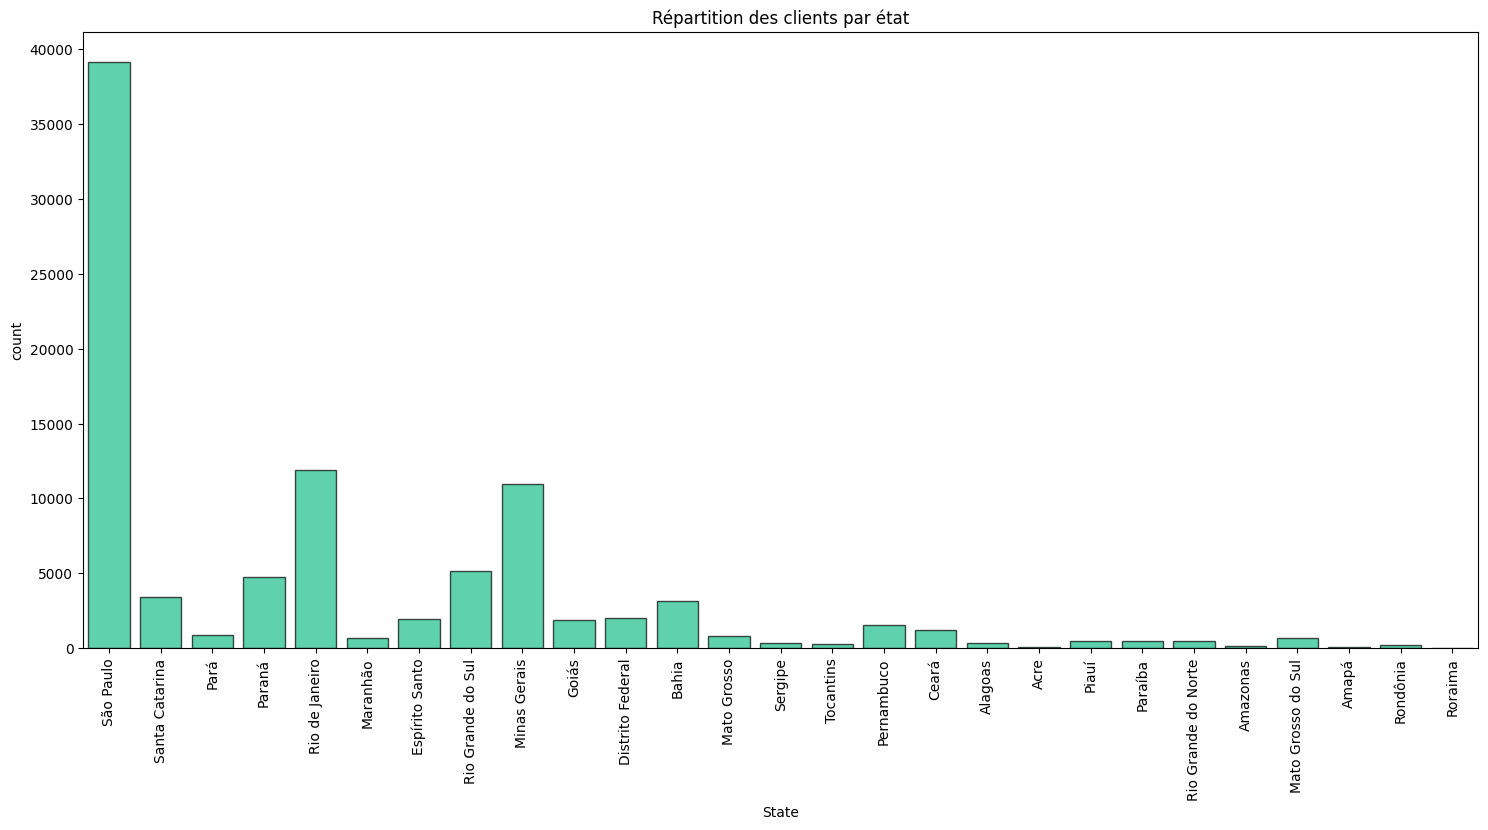

In [24]:
# Utilisation des paramètres de visualisation
fig_size = VISUALIZATION_PARAMS["FIGURE_SIZE_LARGE"]
primary_color = VISUALIZATION_PARAMS["PRIMARY_COLOR"]

plt.figure(figsize=fig_size)
sns.countplot(data=data_agg, x="State", edgecolor="black", color=primary_color, alpha=0.7)
plt.xticks(rotation=90)
plt.title("Répartition des clients par état")
plt.show()

 On observe que la majorité des clients d’Olist proviennent de l’état de São Paulo, qui domine largement avec près de 40 000 clients, suivi par Rio de Janeiro, Minas Gerais et Rio Grande do Sul. Les autres états présentent des effectifs nettement plus faibles

### Boxplot des dépenses totales par état

On visualise la distribution des dépenses totales par état pour détecter d'éventuelles disparités régionales.

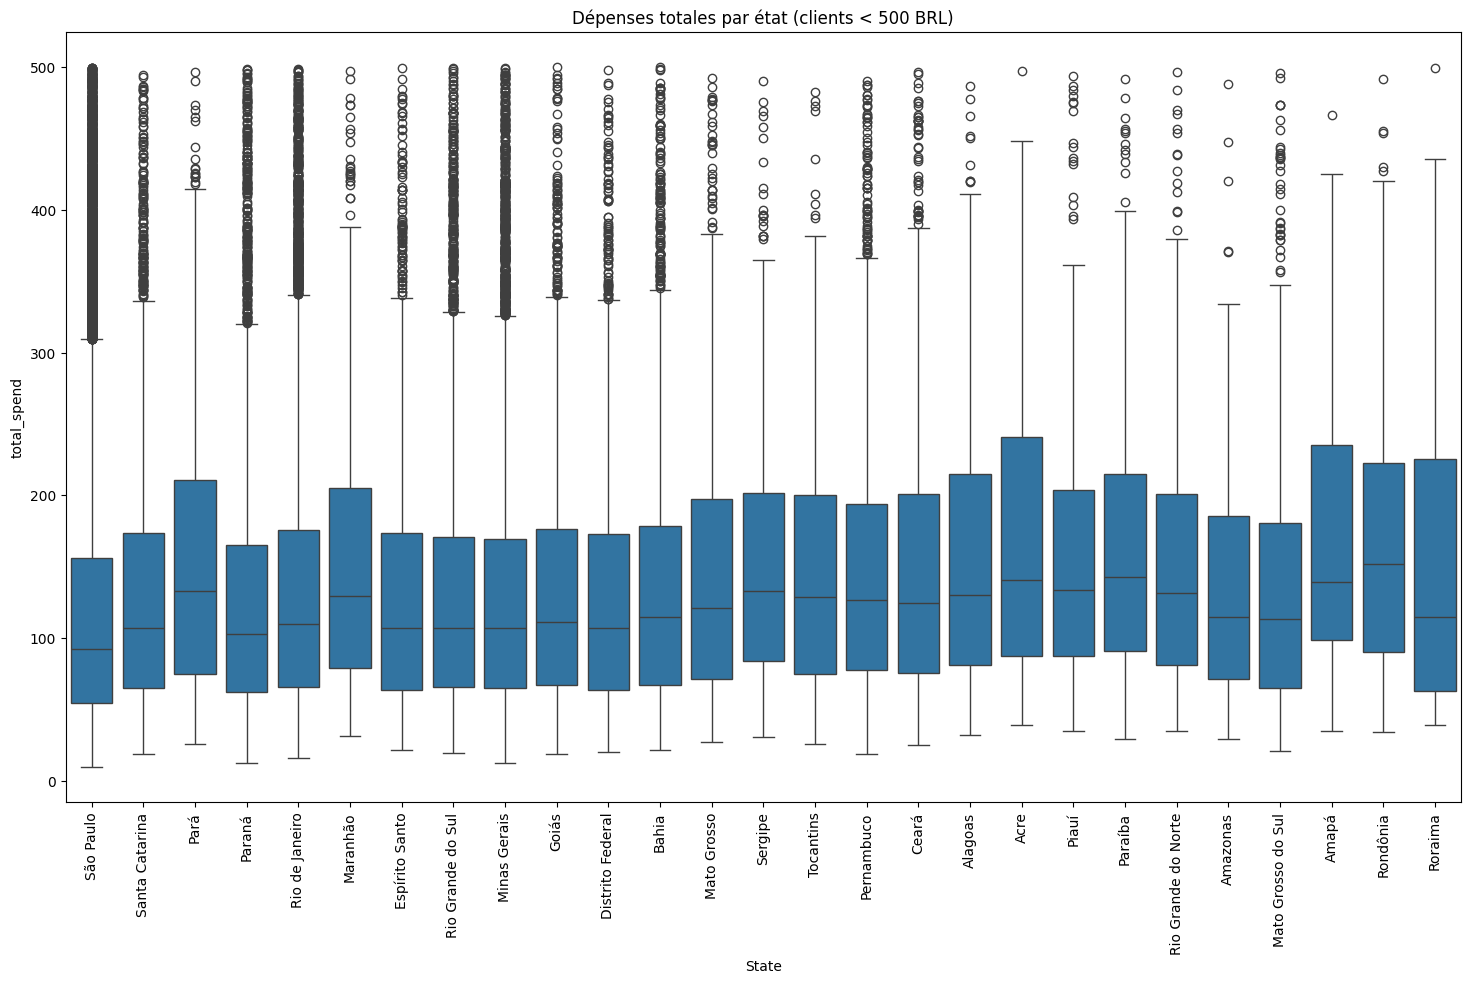

In [25]:
plt.figure(figsize=(18, 10))
sns.boxplot(x="State", y="total_spend", data=data_agg[data_agg["total_spend"] < 500])
plt.xticks(rotation=90)
plt.title("Dépenses totales par état (clients < 500 BRL)")
plt.show()

### Calcul de la distance Haversine entre chaque client et le siège d'Olist

On calcule la distance géographique entre l'état du client et le siège d'Olist pour obtenir une variable de localisation continue et exploitable.

In [26]:
# Moyenne des latitudes et longitudes par état
state_location = geolocation.groupby("geolocation_state")[["geolocation_lat", "geolocation_lng"]].mean().reset_index()

# Coordonnées du siège d'Olist depuis les paramètres
olist_coords = DATA_PARAMS["OLIST_COORDINATES"]
olist_lat = olist_coords["latitude"]
olist_lon = olist_coords["longitude"]

# Calcul de la distance pour chaque état (fonction maintenant importée)
state_location["haversine_distance"] = state_location.apply(
    lambda row: haversine_distance(olist_lat, olist_lon, row["geolocation_lat"], row["geolocation_lng"]), axis=1)

# Jointure avec le dataset client
data_agg = pd.merge(
    data_agg,
    state_location[["geolocation_state", "haversine_distance"]],
    how="left",
    left_on="customer_state",
    right_on="geolocation_state"
)


# Nettoyage final
data_agg.drop(["customer_state", "Code", "geolocation_state"], axis=1, inplace=True)
data_agg = data_agg.rename(columns={"State": "customer_state"})



### Visualisation de la distance Haversine

On affiche la distribution des distances entre les clients et le siège d'Olist.

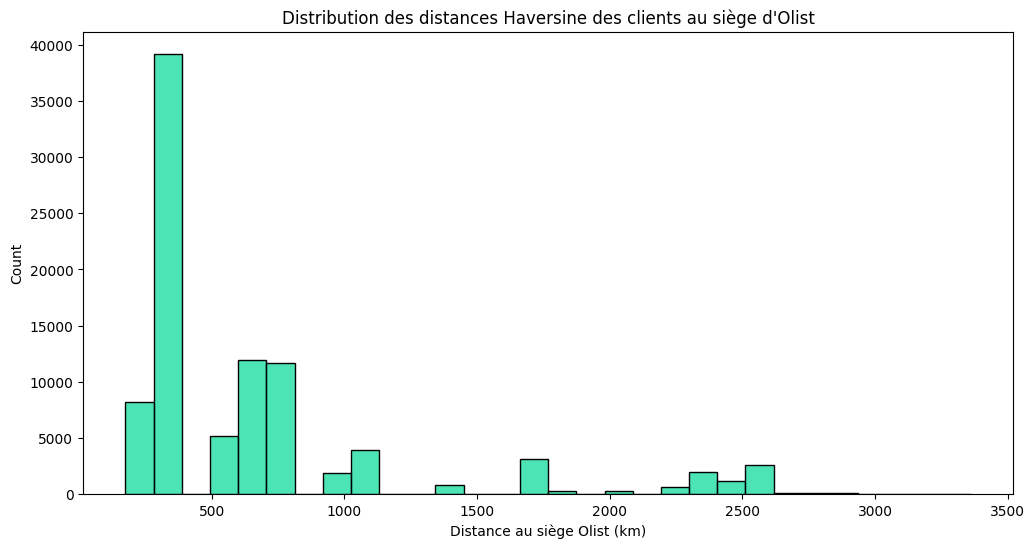

In [27]:
plt.figure(figsize=(12, 6))
sns.histplot(data_agg["haversine_distance"].dropna(), bins=30, color="#00d994", edgecolor="black", alpha=0.7)
plt.xlabel("Distance au siège Olist (km)")
plt.title("Distribution des distances Haversine des clients au siège d'Olist")
plt.show()

## Heatmap de corrélation des variables

Visualisons la matrice de corrélation pour détecter les variables fortement corrélées entre elles.

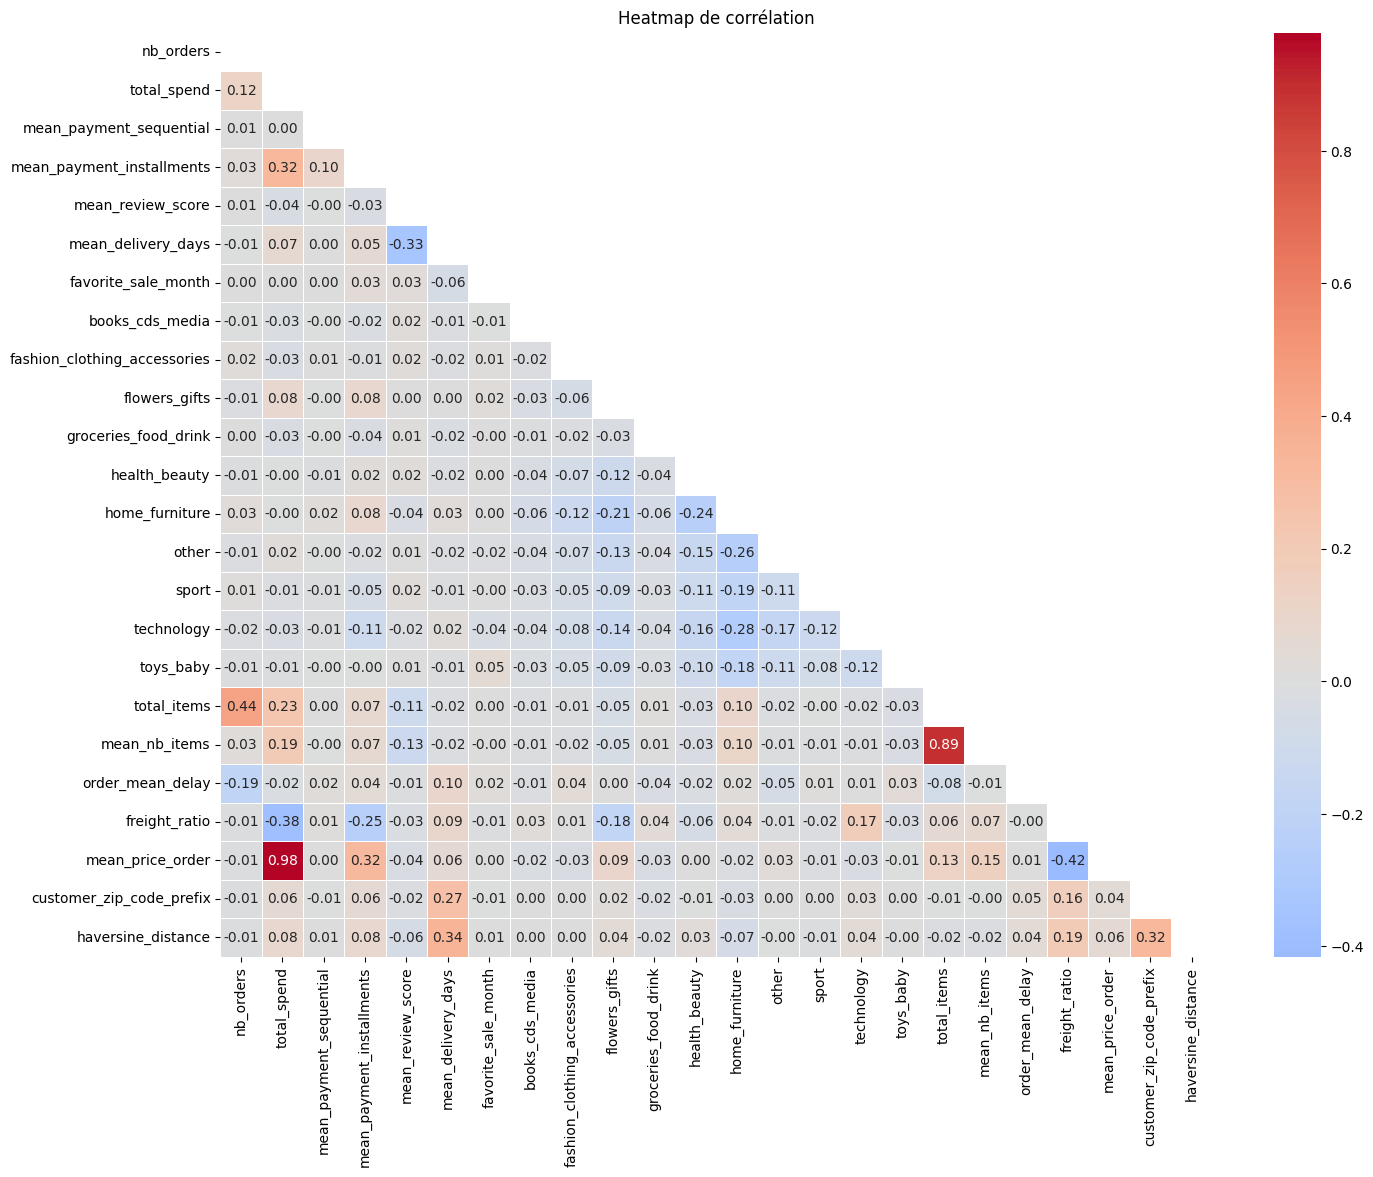

In [28]:
# Sélection des variables numériques pour la corrélation
corr = data_agg.select_dtypes(include=[np.number]).corr()

# Création du masque pour le triangle supérieur
mask = np.triu(np.ones_like(corr, dtype=bool))

# Affichage de la heatmap
plt.figure(figsize=(16, 12))
sns.heatmap(corr, mask=mask, annot=True, fmt='.2f', cmap='coolwarm', center=0, linewidths=0.5)
plt.title('Heatmap de corrélation')
plt.show()

On note que total_spend est très fortement corrélé à mean_price_order (0.98) ce qui est signe de redondance, donc on peut conserver une seule des deux 

In [29]:
data_agg.drop("mean_price_order", axis=1, inplace=True)

Identification des outliers sur les variables numériques clés du projet avec des boxplots pour chaque variable.

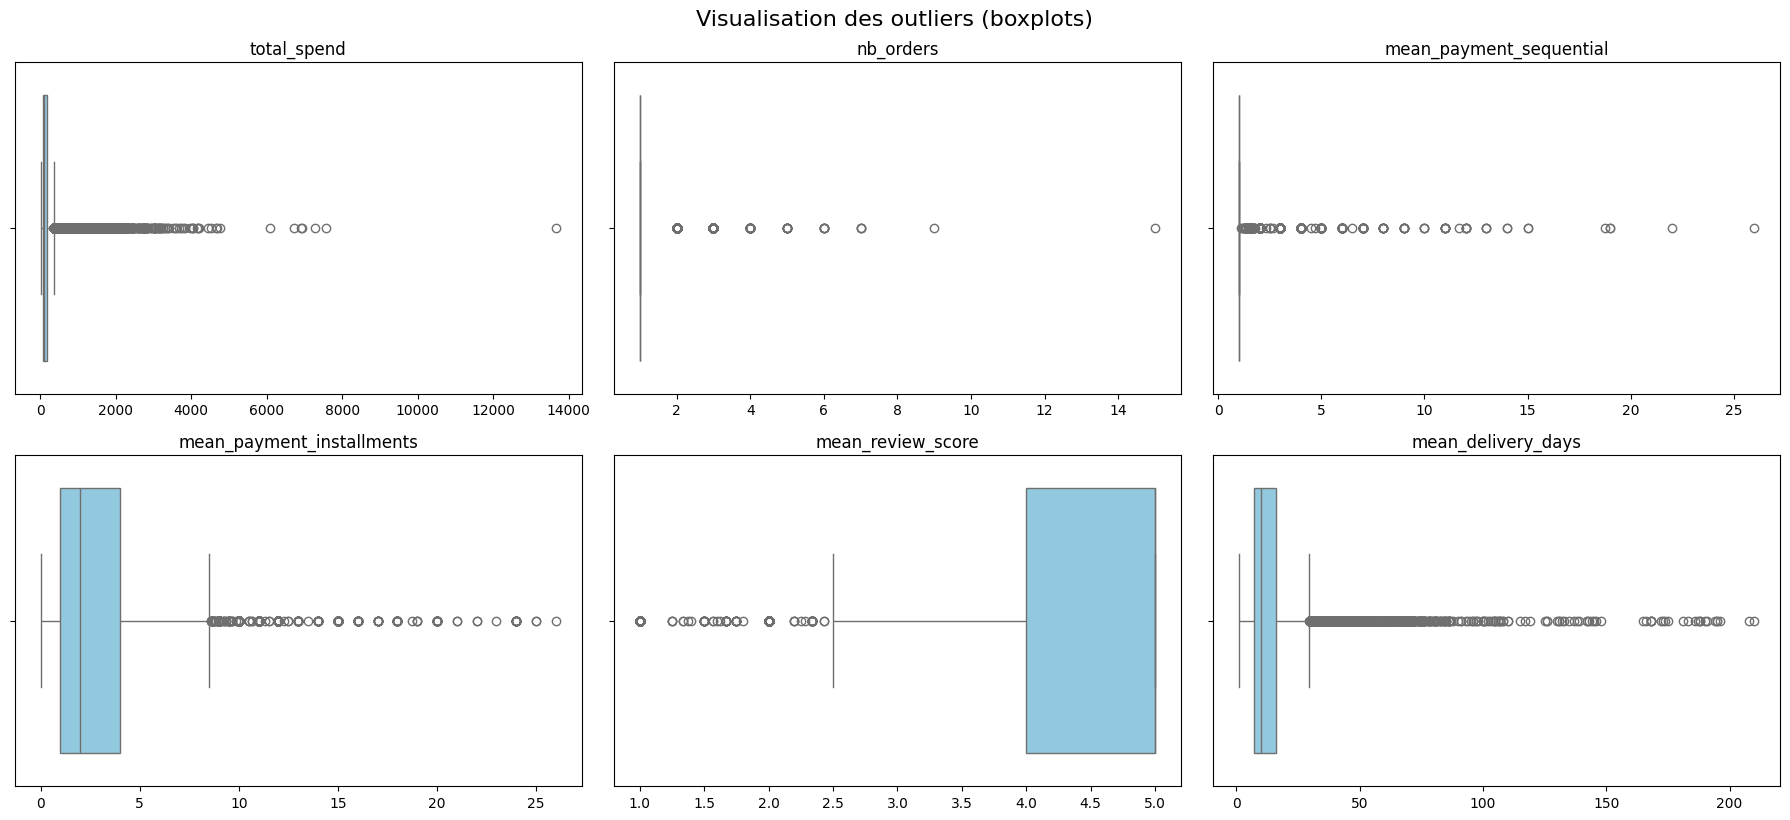

In [30]:
# Utilisation des paramètres pour l'analyse des outliers
features_to_check = FEATURE_ENGINEERING_PARAMS["OUTLIER_ANALYSIS_FEATURES"]

# Filtrer uniquement les colonnes présentes dans le dataset final
features = [col for col in features_to_check if col in data_agg.columns]

# Affichage des boxplots
n_cols = 3
n_rows = (len(features) + n_cols - 1) // n_cols
plt.figure(figsize=(6 * n_cols, 4 * n_rows))

for i, col in enumerate(features, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.boxplot(x=data_agg[col], color='skyblue')
    plt.title(col)
    plt.xlabel("")

plt.tight_layout()
plt.suptitle("Visualisation des outliers (boxplots)", fontsize=16, y=1.02)
plt.show()

- **total_spend** : certains clients dépensent plus de 4000 BRL, ce qui en fait des profils à part avec un comportement d'achat intensif.

- **nb_orders** : la plupart des clients passent entre 1 et 3 commandes, mais une minorité dépasse les 10.

- **mean_payment_sequential / installments** : quelques clients ont des paiements très étalés dans le temps, probablement liés à des habitudes de crédit spécifiques.

- **mean_review_score** : les notes sont globalement très bonnes (autour de 5), avec peu de clients insatisfaits, bien que cela crée un certain déséquilibre.

- **mean_delivery_days** : quelques cas isolés affichent des délais de livraison très longs (plus de 100 jours), probablement des exceptions à traiter comme anomalies.

On peut profiter du jeu de données pour effectuer une imputation des valeurs manquantes avant de l'enregistrer.

In [31]:
# Vérification des valeurs nulles ou NaN 
null_counts = data_agg.isnull().sum()
print("Nombre de valeurs nulles ou NaN par colonne dans data_agg :")
print(null_counts[null_counts > 0])

Nombre de valeurs nulles ou NaN par colonne dans data_agg :
mean_payment_sequential        1
mean_payment_installments      1
mean_review_score            603
mean_delivery_days             8
dtype: int64


In [32]:
# Utilisation des paramètres pour l'imputation
imputation_cols = DATA_PARAMS["IMPUTATION_COLUMNS"]
data_agg = impute_missing_values(data_agg, imputation_cols)

# Vérification après imputation
null_counts = data_agg.isnull().sum()
print("Valeurs nulles restantes après imputation :")
print(null_counts[null_counts > 0])

Valeurs nulles restantes après imputation :
Series([], dtype: int64)


/Users/mac/Desktop/DIC3/MLOps/MLOps_project/ecomuserseg/notebooks/../src/ecomuserseg/feature_engineering.py:191: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data_copy[col].fillna(data_copy[col].mean(), inplace=True)


# Export du dataset client final

On exporte le jeu de données final pour la segmentation client.

In [33]:
# Préparation des données pour le logging
data_initial_stats = pd.DataFrame({
    'dataset': ['customers', 'orders', 'order_items', 'order_payments', 'order_reviews', 'products'],
    'rows': [len(customers), len(orders), len(order_items), len(order_payments), len(order_reviews), len(products)]
})

# Logging des métriques
run_id = log_data_preprocessing(
    data_initial_stats,
    data_final=data_agg,
    run_name=f"preprocessing_{datetime.now().strftime('%Y%m%d_%H%M%S')}"
)

# Export du dataset client final
output_path = DATA_PARAMS["OUTPUT_PATH"]
filename = DATA_PARAMS["FINAL_DATASET_NAME"]
data_agg.to_csv(output_path + filename, index=False)
print(f"📁 Dataset final exporté: {output_path + filename}")

Démarrage du run MLflow: 7c7100231b734a1f902ea252ca3af130
Métriques loggées avec succès dans le run: 7c7100231b734a1f902ea252ca3af130
📁 Dataset final exporté: ../input/client-segmentation/olist-customers-segmentation.csv
📁 Dataset final exporté: ../input/client-segmentation/olist-customers-segmentation.csv
